# Figure 2
Assumes all data is in ../../data

# Setup and load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use FixedLocator along with FixedFormatter
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression


from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    colors_for_sequence,
    format_small_plot,
)

In [2]:
DATA_PATH = "../../data/"

In [3]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Plots

## Figure 2A: reactivity overlap between non-wc and wc

In [13]:
# TODO add helix WC vs flanking pairs
# TODO label both WC and flankingn WC as WC
def plot_figure_2a(df, ax):
    ax = sns.violinplot(
        x="ln_r_data",
        y="r_type",
        data=df,
        hue="r_type",
        order=["WC", "NON-WC"],
        ax=ax,
        linewidth=0.5,
    )
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Nucleotide Type", labelpad=2)
    ax.yaxis.set_major_locator(FixedLocator([0, 1]))
    ax.yaxis.set_major_formatter(FixedFormatter(["WC", "Non-WC"]))
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)
    return ax

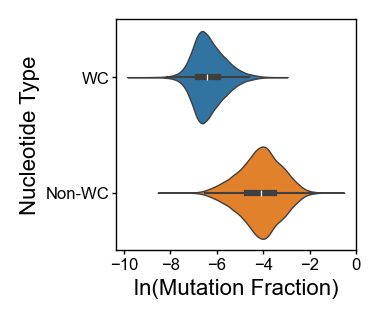

In [5]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2a(df, ax)
plt.savefig("pngs/figure_2a.png", dpi=600)

## Figure 2B: reactivity cummulative distribution

In [6]:
def plot_figure_2b(df, ax):
    df.sort_values("r_type", inplace=True, ascending=True)
    colors = {"WC": "tab:blue", "NON-WC": "tab:orange"}
    # Loop through each unique r_type to plot the cumulative distribution
    for r_type, group_data in df.groupby("r_type"):
        sorted_data = np.sort(group_data["ln_r_data"])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
        ax.plot(sorted_data, cdf, label=r_type, lw=2, color=colors[r_type])
    ax.set_ylabel("Cumulative Distribution (%)", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    format_small_plot(ax)
    return ax

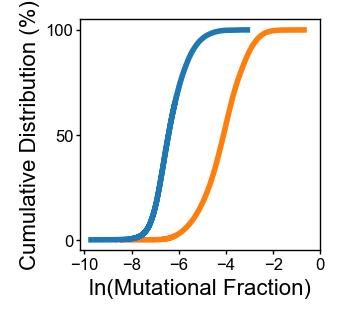

In [7]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2b(df, ax)
plt.savefig("pngs/figure_2b.png", dpi=600)

## Figure 2C: Logistic regression of WC vs non-WC

In [8]:
df["ln_r_data"].replace(-np.inf, -10, inplace=True)
df["ln_r_data"].describe()

count    237528.000000
mean         -5.090406
std           1.367130
min         -10.000000
25%          -6.319969
50%          -5.057727
75%          -3.966479
max          -0.691768
Name: ln_r_data, dtype: float64

In [9]:
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df["r_type_binary"] = df["r_type"].apply(lambda x: 1 if x == "WC" else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df[["ln_r_data"]], df["r_type_binary"])
# Compute probabilities for the original data
df["prob_WC"] = model.predict_proba(df[["ln_r_data"]])[:, 1]
# Display the probabilities
df.sort_values("prob_WC", ascending=False)[["ln_r_data", "r_type", "prob_WC"]]
# df.to_csv("Prob.csv", index=False)

,ln_r_data,r_type,prob_WC
161014,-10.000000,WC,0.999998
28741,-10.000000,WC,0.999998
85313,-10.000000,WC,0.999998
113737,-10.000000,WC,0.999998
18117,-10.000000,WC,0.999998
...,...,...,...
234215,-1.013022,NON-WC,0.000003
234191,-0.994414,NON-WC,0.000003
55879,-0.972755,NON-WC,0.000003
55885,-0.853363,NON-WC,0.000002


In [10]:
def plot_figure_2c(df, ax):
    ax.scatter(df["ln_r_data"], df["prob_WC"], s=1)
    ax.set_ylabel("Probability of WC pair", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    plt.axhline(y=0.5, color="black", linestyle="--", lw=0.5)
    format_small_plot(ax)
    return ax

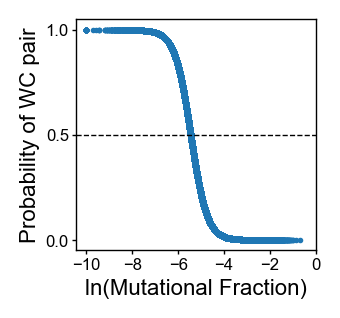

In [11]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_figure_2c(df, ax)
plt.savefig("pngs/figure_2c.png", dpi=600)

## Combined Figure 2A-C


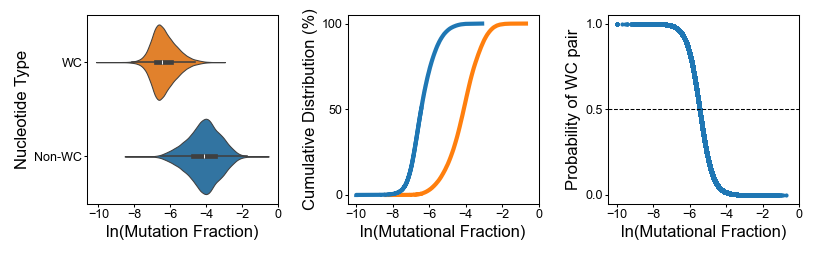

In [73]:
fig = plt.figure(figsize=(5.25, 1.5), dpi=150)
gs = gridspec.GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
plot_figure_2a(df, ax1)
plot_figure_2b(df, ax2)
plot_figure_2c(df, ax3)
gs.tight_layout(fig, pad=0.0, h_pad=0.0, w_pad=1.0)
plt.savefig("pngs/figure_2.png", dpi=600, bbox_inches="tight", pad_inches=0.10)